Epoch 1/20, Loss: 0.026505
Epoch 2/20, Loss: 0.014417
Epoch 3/20, Loss: 0.012399
Epoch 4/20, Loss: 0.011272
Epoch 5/20, Loss: 0.009994
Epoch 6/20, Loss: 0.009620
Epoch 7/20, Loss: 0.009537
Epoch 8/20, Loss: 0.009561
Epoch 9/20, Loss: 0.009422
Epoch 10/20, Loss: 0.009393
Epoch 11/20, Loss: 0.009308
Epoch 12/20, Loss: 0.009315
Epoch 13/20, Loss: 0.009257
Epoch 14/20, Loss: 0.009079
Epoch 15/20, Loss: 0.009061
Epoch 16/20, Loss: 0.009012
Epoch 17/20, Loss: 0.008788
Epoch 18/20, Loss: 0.008709
Epoch 19/20, Loss: 0.008472
Epoch 20/20, Loss: 0.008414


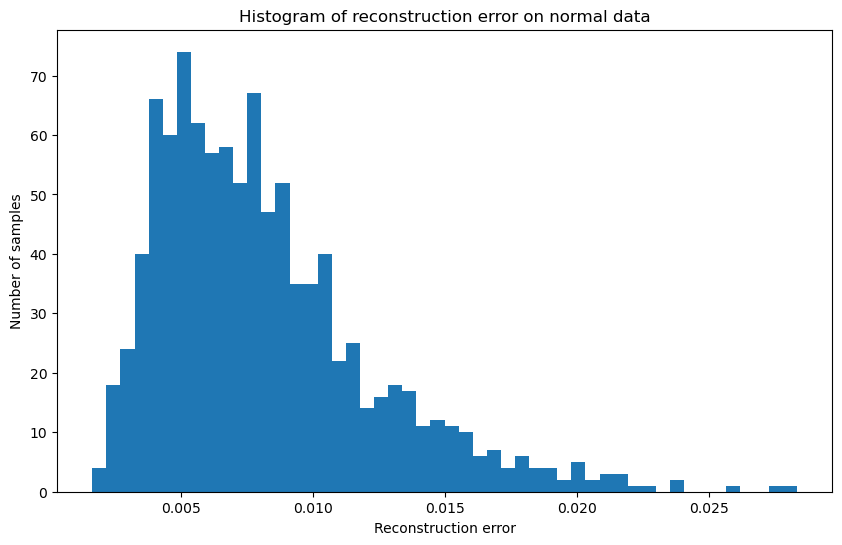

Reconstruction error threshold: 0.016176


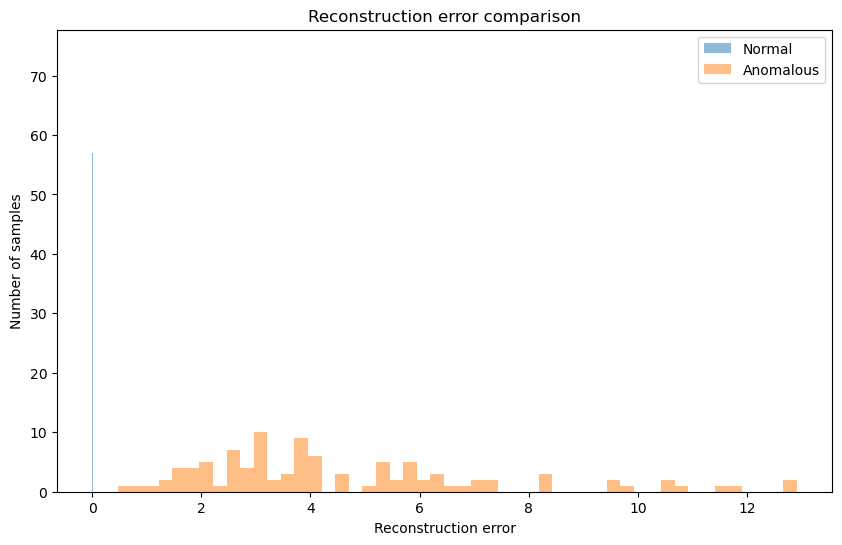

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 设置随机种子以保证可重复性
np.random.seed(42)
torch.manual_seed(42)

# 生成虚拟的正常数据（1000个样本，每个样本长度为100，特征维度为3，即x、y、z坐标）
def generate_normal_data(num_samples=1000, seq_length=100):
    data = []
    for _ in range(num_samples):
        # 模拟正常的坐标变化，添加一些小的随机噪声
        x = np.cumsum(np.random.normal(0, 0.02, seq_length))
        y = np.cumsum(np.random.normal(0, 0.02, seq_length))
        z = np.cumsum(np.random.normal(0, 0.02, seq_length))
        sequence = np.stack((x, y, z), axis=1)
        data.append(sequence)
    return np.array(data)

# 生成数据
normal_data = generate_normal_data()

# 转换为PyTorch张量
normal_data = torch.from_numpy(normal_data).float()

# 创建数据集和数据加载器
batch_size = 32
dataset = TensorDataset(normal_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定义LSTM自动编码器模型
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(
            input_size=n_features, hidden_size=embedding_dim, num_layers=1, batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim, hidden_size=n_features, num_layers=1, batch_first=True
        )
        
    def forward(self, x):
        # 编码
        _, (hidden, _) = self.encoder(x)
        # 将编码的隐状态重复seq_len次，以便解码器输入
        hidden = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        # 解码
        decoded, _ = self.decoder(hidden)
        return decoded

# 初始化模型、损失函数和优化器
seq_len = normal_data.shape[1]
n_features = normal_data.shape[2]
model = LSTMAutoencoder(seq_len, n_features)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        seqs = batch[0]
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, seqs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.6f}")

# 在训练数据上计算重构误差
model.eval()
with torch.no_grad():
    reconstructed = model(normal_data)
    losses = torch.mean((reconstructed - normal_data) ** 2, dim=(1,2)).numpy()

# 可视化重构误差
plt.figure(figsize=(10,6))
plt.hist(losses, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.title('Histogram of reconstruction error on normal data')
plt.show()

# 设置一个阈值来检测异常
threshold = np.percentile(losses, 95)
print(f"Reconstruction error threshold: {threshold:.6f}")

# 生成一些异常数据进行测试
def generate_anomalous_data(num_samples=100, seq_length=50):
    data = []
    for _ in range(num_samples):
        x = np.cumsum(np.random.normal(0, 0.5, seq_length))
        y = np.cumsum(np.random.normal(0, 0.5, seq_length))
        z = np.cumsum(np.random.normal(0, 0.5, seq_length))
        sequence = np.stack((x, y, z), axis=1)
        data.append(sequence)
    return np.array(data)

anomalous_data = generate_anomalous_data()
anomalous_data = torch.from_numpy(anomalous_data).float()

# 计算异常数据的重构误差
with torch.no_grad():
    reconstructed = model(anomalous_data)
    anomalous_losses = torch.mean((reconstructed - anomalous_data) ** 2, dim=(1,2)).numpy()

# 可视化正常和异常数据的重构误差
plt.figure(figsize=(10,6))
plt.hist(losses, bins=50, alpha=0.5, label='Normal')
plt.hist(anomalous_losses, bins=50, alpha=0.5, label='Anomalous')
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.legend()
plt.title('Reconstruction error comparison')
plt.show()
